In [0]:
import numpy as np
from matplotlib import pylab as plt
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow import keras
from itertools import combinations, permutations
from copy import copy, deepcopy
from sys import setrecursionlimit
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

np.seterr(over='raise', invalid='raise')
random.seed(42)
np.random.seed(42)

setrecursionlimit(1500)

# WANN

In [0]:
class Function:
    def __init__(self, function, priority_key):
        self.function = function
        self.priority_key = priority_key

    def __str__(self):
        return str(self.function)
  
    def __lt__(self, other):
        return self.priority_key < other.priority_key

    def __call__(self, *args):
        return self.function(*args)

def create_function_list(functions):
    key = 0
    functions_list = []
    for f in functions:
        functions_list.append(Function(f, key))
        key += 1
    return functions_list

In [0]:
class WANN1:
    class Node:
        def __init__(self, function, parents):
            self.function = function
            self.parents = parents

    class Layer:
        def __init__(self, size, prev_layer_size, function_list):
            self.nodes = [WANN1.Node(copy(random.choice(function_list)), []) for
                          _ in range(size)]
            self.connect(prev_layer_size)

        def __iter__(self):
            return iter(self.nodes)

        def __getitem__(self, key):
            return self.nodes[key]

        def __setitem__(self, key, value):
            self.nodes[key] = value

        def __len__(self):
            return len(self.nodes)

        def connect(self, prev_layer_size):
            for node in self.nodes:
                node.parents = set()
            inds = np.random.randint(0, len(self), prev_layer_size)
            for i, k in enumerate(inds):
                self.nodes[k].parents.add(i)
            for node in self.nodes:
                if len(node.parents) == 0:
                    parents_num = np.random.randint(1, prev_layer_size + 1)
                else:
                    parents_num = np.random.randint(0, prev_layer_size + 1)
                node.parents = node.parents.union(set(random.sample(
                    range(prev_layer_size), parents_num)))
                node.parents = list(node.parents)
                

        def calculate(self, X, params):
            Y = np.zeros((params.size, X.shape[1], len(self.nodes)))
            for i in range(len(self.nodes)):
                Y[:, :, i] = self.nodes[i].function((X[:, :, self.nodes[i].
                                                       parents].sum(axis=2) + 1)*
                                                    params[:, np.newaxis])
            return Y
            
    def __init__(self):
        self.input_len = 0
        self.output_len = 0
        self.layers = []

    def __len__(self):
        return len(self.layers)

    def __iter__(self):
        return iter(self.layers)

    def __getitem__(self, key):
        return self.layers[key]

    def __setitem__(self, key, value):
        self.layers[key] = value

    def generate(self, input_len, layers_size, output_len, 
                 function_list, output_function_list):
        self.input_len = input_len
        self.output_len = output_len
        self.layers.clear()
        prev_layer_size = input_len
        for bounds in layers_size:
            layer_size = random.randint(*bounds)
            layer = WANN1.Layer(layer_size, prev_layer_size, function_list)
            self.layers.append(layer)
            prev_layer_size = layer_size
        layer = self.Layer(output_len, prev_layer_size, output_function_list)
        self.layers.append(layer)

    def insert_random_layer(self, layer_size, function_list):
        n = len(self)
        i = np.random.randint(0, n)
        layer_size = random.randint(*layer_size)
        if i == 0:
            prev_layer_size = self.input_len
        else:
            prev_layer_size = len(self[i - 1])
        new_layer = WANN1.Layer(layer_size, prev_layer_size, function_list)
        self[i].connect(layer_size)
        self.layers.insert(i, new_layer)

    def delete_random_layer(self):
        n = len(self)
        if n == 1:
            return
        layer_to_remove = np.random.randint(0, n - 1)
        self.layers.pop(layer_to_remove)
        if layer_to_remove == 0:
            prev_layer_size = self.input_len
        else:
            prev_layer_size = len(self[layer_to_remove - 1])
        self[layer_to_remove].connect(prev_layer_size)

    def change_random_layer(self, new_layer_size, function_list, output_function_list):
        layer_size = random.randint(*new_layer_size)
        n = len(self)
        layer_to_replace = np.random.randint(0, n)
        if layer_to_replace == 0:
            prev_layer_size = self.input_len
        else:
            prev_layer_size = len(self[layer_to_replace - 1])
        if layer_to_replace != n - 1:
            self[layer_to_replace] = WANN1.Layer(layer_size, 
                                                 prev_layer_size, function_list)
            self[layer_to_replace + 1].connect(layer_size)
        else:
            self[layer_to_replace] = WANN1.Layer(self.output_len, prev_layer_size, 
                                                 output_function_list)

    def print(self):
        for layer in self.layers:
            print("=============")
            print(f"Layer size {len(layer)}")
            for node in layer:
                print(f"  {node.function}  {node.parents}")

    def forward(self, X, params):
        X_input = X[np.newaxis, :]
        for layer in self.layers:
            X_input = layer.calculate(X_input, params)
        return X_input

In [0]:
class WANN2:
    class Node:
        def __init__(self, function, parents, index, input_layer, output_layer):
            self.function = function
            self.parents = parents
            self.index = index
            self.input_layer = input_layer
            self.output_layer = output_layer
        
        def calculate(self, X, params, calculated, nodes):
            if self.input_layer:
                X_input = X[:, self.parents[0]][np.newaxis, :]
                calculated[self.index] = X_input
                return
            X_input = np.zeros((len(params), X.shape[0], len(self.parents)))
            j = 0
            for i in self.parents:
                if type(calculated[i]) == bool:
                    nodes[i].calculate(X, params, calculated, nodes)
                X_input[:, :, j] = calculated[i]
                j += 1
            calculated[self.index] = self.function((X_input.sum(axis=2) + 1)*
                                                    params[:, np.newaxis])
            
    def __init__(self, input_len, output_len, output_function_list):
        self.input_len = input_len
        self.output_len = output_len
        self.nodes = []
        self.output_nodes = list(range(input_len, input_len + output_len))
        for i in range(input_len):
            self.nodes.append(WANN2.Node(0, [i], i, True, False))
        for i in range(input_len, input_len + output_len):
            parents_num = np.random.randint(1, input_len + 1)
            parents = random.sample(range(input_len), parents_num)
            self.nodes.append(WANN2.Node(copy(random.choice(output_function_list)),
                                         parents, i, False, True))

    def __len__(self):
        return len(self.nodes)
    
    def add_random_node(self, function_list):
        node1 = random.choice(self.nodes[self.input_len:])
        node2 = random.choice(node1.parents)
        node1.parents.remove(node2)
        node1.parents.append(len(self.nodes))
        new_node = WANN2.Node(copy(random.choice(function_list)), 
                              [node2], len(self.nodes),
                              False, False)
        self.nodes.append(new_node)

    def add_random_edge(self):
        node1 = random.choice(self.nodes[self.input_len:])
        node2 = np.random.randint(0, self.input_len)
        node1.parents = list(set(node1.parents).union({node2}))

    def change_random_node(self, function_list, output_function_list):
        node = random.choice(self.nodes[self.input_len:])
        if node.output_layer:
            node.function = copy(random.choice(output_function_list))
        else:
            node.function = copy(random.choice(function_list))

    def print(self):
        print(f'input len = {self.input_len}  output_len = {self.output_len}')
        for node in self.nodes:
            print(f'node id = {node.index} input = {node.input_layer}, output = {node.output_layer}')
            print(f'activation function - {node.function}')
            print(f'parents = {node.parents}')


    def forward(self, X, params):
        calculated = [False]*len(self.nodes)
        for i in self.output_nodes:
            self.nodes[i].calculate(X, params, calculated, self.nodes)
        return np.concatenate([calculated[i] for i in self.output_nodes],
                              axis=1).reshape(
                                  (len(params), -1, X.shape[0])).transpose((0, 2, 1))

In [0]:
def mean_error(wann, X, Y, params):
    return np.linalg.norm(wann.forward(X, params) - 
                          Y, axis=1).mean()/X.shape[0]

def max_error(wann, X, Y, params):
    return np.linalg.norm(wann.forward(X, params) - 
                          Y, axis=1).mean(axis=1).max()/X.shape[0]

def min_error(wann, X, Y, params):
    return np.linalg.norm(wann.forward(X, params) - 
                          Y, axis=1).mean(axis=1).min()/X.shape[0]

In [0]:
def regularizer(wann, max_size):
    return 1 if len(wann) <= max_size else 999

In [0]:
def get_error_with_regularizer(error, regularizer, *args):
    def f(wann, X, Y, params):
        return error(wann, X, Y, params)*regularizer(wann, *args)
    return f

In [0]:
def optimise_param(wann, X, Y, grid):
    k = np.linalg.norm(wann.forward(X, grid) - Y, axis=1).mean(axis=1).argmin()
    return grid[k]

# Metrics

In [0]:
def diam(T, metric, *args):
    d = 0
    for t1, t2 in combinations(T, 2):
        d = max(metric(t1, t2, *args), d)
    return d

def calc_dist_matrix(metric, T, *args):
    dist_matrix = np.zeros((len(T), len(T)))
    for i in range(len(T)):
        for j in range(i + 1, len(T)):
            d = metric(T[i], T[j], *args)
            dist_matrix[i][j] = d
            dist_matrix[j][i] = d
    return dist_matrix

## Standart metrics

In [0]:
def standart_metric1(wann1, wann2, X, params):
    Y1 = wann1.forward(X, params)
    Y2 = wann2.forward(X, params)
    return np.linalg.norm(Y1 - Y2, axis=1).mean()/X.shape[0]

def standart_metric2(wann1, wann2, X, params):
    Y1 = wann1.forward(X, params)
    Y2 = wann2.forward(X, params)
    return np.linalg.norm(Y1[np.newaxis, :] - 
                          Y2[:, np.newaxis], axis=(2, 3)).max()/X.shape[0]

## Structural metrics

In [0]:
def wann_to_matrix(wann, functions_num):
    n = functions_num
    matrix = np.zeros((n + wann.input_len, n))
    if type(wann) == WANN1:
        for i in range(len(wann.layers) - 1, 0, -1):
            for node1 in wann.layers[i]:
                for node2 in map(lambda x: wann.layers[i-1].nodes[x], node1.parents):
                    matrix[node2.function.priority_key][node1.function.priority_key] += 1
        for node in wann.layers[0]:
            for x in node.parents:
                matrix[n + x][node.function.priority_key] += 1
    elif type(wann) == WANN2:
        for node in wann.nodes[wann.input_len:]:
            for parent in node.parents:
                if wann.nodes[parent].input_layer:
                    matrix[n + parent][node.function.priority_key] += 1
                else:
                    matrix[wann.nodes[parent].function.
                           priority_key][node.function.priority_key] += 1
    return matrix

In [0]:
def structural_metric1(wann1, wann2, functions_num):
    matrix1 = wann_to_matrix(wann1, functions_num)
    matrix2 = wann_to_matrix(wann2, functions_num)
    return np.linalg.norm(matrix1 - matrix2)

def structural_metric2(wann1, wann2, functions_num, net):
    matrix1 = wann_to_matrix(wann1, functions_num)
    matrix2 = wann_to_matrix(wann2, functions_num)
    return net.predict(np.array([np.abs(matrix1 - matrix2)]))[0][0]

def fit_net(T_train, metric_to_predict, functions_num, epochs, *args):
    k = T_train[0].input_len
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(functions_num + k, functions_num)),
        keras.layers.Dense(128, activation='linear'),
        keras.layers.Dense(128, activation='sigmoid'),
        keras.layers.Dense(32, activation='linear'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='mse',
                metrics=['mse'])
    
    X_train = []
    y_train = []
    for wann1, wann2 in combinations(T_train, 2):
        y_train.append(metric_to_predict(wann1, wann2, *args))
        matrix1 = wann_to_matrix(wann1, functions_num)
        matrix2 = wann_to_matrix(wann2, functions_num)
        X_train.append(np.abs(matrix1 - matrix2))
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    model.fit(X_train, y_train, epochs=epochs)
    return model

## Comparing metrics

In [0]:
def compare_metrics1(dist_matrix1, dist_matrix2):
    return pearsonr(dist_matrix1.flatten(), dist_matrix2.flatten())[0]

def compare_metrics2(dist_matrix1, dist_matrix2):
    m = 0
    n = dist_matrix1.shape[0]
    for i, j, k in permutations(range(n), 3):
        m += ((dist_matrix1[i][j] - dist_matrix1[i][k])*
              (dist_matrix2[i][j] - dist_matrix2[i][k]) < 0)
    return m/(n*(n-1)*(n-2))

def compare_metrics3(dist_matrix1, dist_matrix2):
    A = dist_matrix1.copy()
    B = dist_matrix2.copy()
    A[A == 0] = -1
    B[B == 0] = -1
    C = A/B
    C[C < 0] = C.mean()
    return C.min()/C.max()

def compare_metrics4(dist_matrix1, dist_matrix2):
    n = dist_matrix1.size
    dist_matrix1 = dist_matrix1/dist_matrix1.max()
    dist_matrix2 = dist_matrix2/dist_matrix2.max()
    return np.linalg.norm(dist_matrix1.reshape((n, 1)) - 
                          dist_matrix2.reshape(n, 1))
    
def compare_metrics(comparators, T, metrics1, metrics2, args1, args2):
    D1 = [calc_dist_matrix(metric, T, *args) for args,
          metric in zip(args1, metrics1)]
    D2 = [calc_dist_matrix(metric, T, *args) for args,
          metric in zip(args2, metrics2)]
    output = []
    for comparator in comparators:
        output_matrix = np.zeros((len(metrics1),
                                  len(metrics2)))
        for i in range(len(metrics1)):
            for j in range(len(metrics2)):
                output_matrix[i][j] = comparator(D1[i], D2[j])
        output.append(output_matrix)
    return output

# Genetic algorithms

In [0]:
def generate_first_population1(size, input_len, layers_size,
                               output_len, function_list, output_function_list):
    population = [WANN1() for _ in range(size)]
    for wann in population:
        wann.generate(input_len, layers_size, output_len,
                      function_list, output_function_list)
    return population


def generate_first_population2(size, input_len, output_len, output_function_list):
    population = [WANN2(input_len, output_len,
                        output_function_list) for _ in range(size)]
    return population


def mutate1(population, mutations_num, new_layer_size, 
            weights, function_list, output_function_list):
    mutated = [deepcopy(wann) for wann in 
               random.choices(population, k=mutations_num)]
    for wann in mutated:
        operation = random.choices(range(-1, 2), weights=weights)[0]
        if operation == -1:
            wann.delete_random_layer()
        elif operation == 0:
            wann.change_random_layer(new_layer_size, 
                                     function_list, output_function_list)
        elif operation == 1:
            wann.insert_random_layer(new_layer_size, function_list)
    return mutated


def mutate2(population, mutations_num, operations_num,
            weights, function_list, output_function_list):
    mutated = [deepcopy(wann) for wann in 
               random.choices(population, k=mutations_num)]
    for wann in mutated:
        for _ in range(random.randint(*operations_num)):
            operation = random.choices(range(-1, 2), weights=weights)[0]
            if operation == -1:
                wann.change_random_node(function_list, output_function_list)
            elif operation == 0:
                wann.add_random_edge()
            elif operation == 1:
                wann.add_random_node(function_list)
    return mutated


def crossover(population, crossovers_num):
    crossovered = []
    for _ in range(crossovers_num):
        wann1, wann2 = random.sample(population, 2)
        k = np.random.randint(len(wann1))
        m = np.random.randint(len(wann2))
        wann = WANN1()
        wann.input_len = wann1.input_len
        wann.output_len = wann2.output_len
        for i in range(k + 1):
            wann.layers.append(deepcopy(wann1[i]))
        for j in range(m, len(wann2)):
            wann.layers.append(deepcopy(wann2[j]))
        prev_layer_size = len(wann.layers[k])
        wann[k + 1].connect(prev_layer_size)
        crossovered.append(wann)
    return crossovered

In [0]:
def genetic_alg_classic1(X, Y, params, population_size, input_len, layers_size, 
                        output_len, function_list, output_function_list,
                        mutations_num, crossovers_num,
                        mutation_layer_size, weights, error, 
                        eps, max_epochs=100, return_history=False):
    
    population = generate_first_population1(population_size, input_len, 
                                            layers_size, output_len, 
                                            function_list, output_function_list)
    history = []

    for _ in range(max_epochs):
        mutated = mutate1(population, mutations_num, mutation_layer_size, weights, 
                          function_list, output_function_list)
        crossovered = crossover(population, crossovers_num)
        population = population + mutated + crossovered
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]
        
        if return_history:
            history.append(errors[0])
        
        if errors[0] <= eps:
            break

    if return_history:
        return population[0], history
    return population[0]


def genetic_alg_classic2(X, Y, params, population_size,
                         input_len, output_len, function_list, 
                         output_function_list, mutations_num,
                         mutation_strength, weights, error,
                         eps, max_epochs=100, return_history=False):
    
    population = generate_first_population2(population_size, 
                                            input_len, output_len,
                                            output_function_list)
    history = []

    for _ in range(max_epochs):
        mutated = mutate2(population, mutations_num, mutation_strength, weights,
                          function_list, output_function_list)
        population = population + mutated
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]
        
        if return_history:
            history.append(errors[0])
        
        if errors[0] <= eps:
            break

    if return_history:
        return population[0], history
    return population[0]


def genetic_alg_diam1(X, Y, params, population_size, input_len, layers_size, 
                        output_len, function_list, output_function_list,
                        mutations_num, crossovers_num, mutation_layer_size, 
                        regeneration_layers_size, weights, error, 
                        metric, frequency, delta, eps,
                        max_epochs=100, return_history=False, *args):
    
    population = generate_first_population1(population_size, input_len, layers_size,
                                            output_len, function_list, output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate1(population, mutations_num, mutation_layer_size, weights,
                          function_list, output_function_list)
        crossovered = crossover(population, crossovers_num)
        population = population + mutated + crossovered
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), 
                                         key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]
        
        if return_history:
            history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if (epoch + 1)%frequency == 0:
            if diam(population, metric, *args) <= delta:
                for wann in population[population_size//2 :]:
                    wann.generate(input_len, regeneration_layers_size, output_len,
                                  function_list, output_function_list)

    if return_history:
        return population[0], history
    return population[0]


def genetic_alg_diam2(X, Y, params, population_size, input_len, output_len,
                      function_list, output_function_list, mutations_num,
                      mutation_strength, regeneration_strength, weights,
                      error, metric, frequency, delta, eps,
                      max_epochs=100, return_history=False, *args):
    
    population = generate_first_population2(population_size, input_len, 
                                            output_len, output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate2(population, mutations_num, mutation_strength, 
                          weights, function_list, output_function_list)
        population = population + mutated
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), 
                                         key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]
        
        if return_history:
            history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if (epoch + 1)%frequency == 0:
            if diam(population, metric, *args) <= delta:
                for wann in population[population_size//2 :]:
                    wann = WANN2(input_len, output_len, output_function_list)
                    for _ in range(random.randint(*regeneration_strength)):
                        operation = random.choices(range(-1, 2),
                                                   weights=weights)[0]
                        if operation == -1:
                            wann.change_random_node(function_list, 
                                                    output_function_list)
                        elif operation == 0:
                            wann.add_random_edge()
                        elif operation == 1:
                            wann.add_random_node(function_list)

    if return_history:
        return population[0], history
    return population[0]


def genetic_alg_err1(X, Y, params, population_size, input_len, layers_size, 
                        output_len, output_function_list, function_list,
                        mutations_num, crossovers_num, mutation_layer_size, 
                        regeneration_layers_size, weights, error, 
                        frequency, delta, eps, 
                        max_epochs=100, return_history=False):
    
    population = generate_first_population1(population_size, input_len, 
                                            layers_size,
                                            output_len, function_list, 
                                            output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate1(population, mutations_num, mutation_layer_size, 
                          weights,function_list, output_function_list)
        crossovered = crossover(population, crossovers_num)
        population = population + mutated + crossovered
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), 
                                         key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]

        history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if epoch%frequency == 0 and epoch > 0:
            if history[-1]/history[epoch - frequency] > delta:
                for wann in population[population_size//2 :]:
                    wann.generate(input_len, 
                                  regeneration_layers_size,
                                  output_len,
                                  function_list, output_function_list)

    if return_history:
        return population[0], history
    return population[0]

def genetic_alg_err2(X, Y, params, population_size, input_len,
                     output_len, function_list,
                     output_function_list, mutations_num, 
                     mutation_strength, regeneration_strength,
                     weights, error, frequency, delta, eps,
                     max_epochs=100, return_history=False):
    population = generate_first_population2(population_size, input_len, 
                                            output_len, output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate2(population, mutations_num, mutation_strength, weights,
                          function_list, output_function_list)
        population = population + mutated
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]
        
        history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if epoch%frequency == 0 and epoch > 0:
            if history[-1]/history[epoch - frequency] > delta:
                for wann in population[population_size//2 :]:
                    wann = WANN2(input_len, output_len, output_function_list)
                    for _ in range(random.randint(*regeneration_strength)):
                        operation = random.choices(range(-1, 2), 
                                                   weights=weights)[0]
                        if operation == -1:
                            wann.change_random_node(function_list, 
                                                    output_function_list)
                        elif operation == 0:
                            wann.add_random_edge()
                        elif operation == 1:
                            wann.add_random_node(function_list)

    if return_history:
        return population[0], history
    return population[0]

def genetic_alg_cluster1(X, Y, params, population_size, input_len, layers_size, 
                        output_len, output_function_list, function_list,
                        mutations_num, crossovers_num, mutation_layer_size, 
                        regeneration_layers_size, weights, error, metric, 
                        frequency, delta, eps, max_epochs=100,
                         return_history=False, *args):

    population = generate_first_population1(population_size, input_len, layers_size, 
                                            output_len, function_list, output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate1(population, mutations_num, mutation_layer_size, weights,
                          function_list, output_function_list)
        crossovered = crossover(population, crossovers_num)
        population = population + mutated + crossovered
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), 
                                         key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]

        history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if epoch%frequency == 0 and epoch > 0:
            if history[-1]/history[epoch - frequency] > delta:
                dist_matrix = calc_dist_matrix(metric, population, *args)
                clustering = AgglomerativeClustering().fit(dist_matrix)
                labels = np.array(clustering.labels_)
                errors = np.array(errors)
                for label in set(labels):
                    indexes = np.argwhere(labels==label).flatten()
                    cluster = [population[i] for i in indexes]
                    cluster_errors = errors[indexes]
                    i = cluster_errors.argmin()
                    for j, wann in enumerate(cluster):
                        if j != i:
                            wann.generate(input_len, regeneration_layers_size,
                                          output_len, function_list, 
                                          output_function_list)

    if return_history:
        return population[0], history
    return population[0]


def genetic_alg_cluster2(X, Y, params, population_size, input_len, output_len, 
                         function_list, output_function_list, mutations_num,
                         mutation_strength, regeneration_strength, weights,
                         error, metric, frequency, delta, eps, max_epochs=100,
                         return_history=False, *args):
    population = generate_first_population2(population_size, 
                                            input_len, output_len,
                                            output_function_list)
    history = []

    for epoch in range(max_epochs):
        mutated = mutate2(population, mutations_num, mutation_strength, weights,
                          function_list, output_function_list)
        population = population + mutated
        errors = [error(wann, X, Y, params) for wann in population]
        population, errors = zip(*sorted(zip(population, errors), 
                                         key=lambda x: x[1]))
        population = list(population)
        errors = list(errors)
        population = population[:population_size]

        history.append(errors[0])
        
        if errors[0] <= eps:
            break

        if epoch%frequency == 0 and epoch > 0:
            if history[-1]/history[epoch - frequency] > delta:
                dist_matrix = calc_dist_matrix(metric, population, *args)
                clustering = AgglomerativeClustering().fit(dist_matrix)
                labels = np.array(clustering.labels_)
                errors = np.array(errors)
                for label in set(labels):
                    indexes = np.argwhere(labels==label).flatten()
                    cluster = [population[i] for i in indexes]
                    cluster_errors = errors[indexes]
                    i = cluster_errors.argmin()
                    for j, wann in enumerate(cluster):
                        if j != i:
                            wann = WANN2(input_len, output_len, 
                                         output_function_list)
                            for _ in range(random.randint(*regeneration_strength)):
                                operation = random.choices(range(-1, 2), 
                                                           weights=weights)[0]
                                if operation == -1:
                                    wann.change_random_node(function_list, 
                                                            output_function_list)
                                elif operation == 0:
                                    wann.add_random_edge()
                                elif operation == 1:
                                    wann.add_random_node(function_list)


    if return_history:
        return population[0], history
    return population[0]

#Experiments

In [0]:
def normalise(X):
    return (X - X.min(axis=0))/(X.max(axis=0) - X.min(axis=0))

In [0]:
def sigmoid(x):
    return 1/(1 + np.exp(-np.clip(x, -700, 700)))

def step(x):
    return x > 0

def gauss(x):
    return np.exp(-x**2)

def softsign(x):
    return 1/(1 + np.abs(x))

function_list = create_function_list([sigmoid, gauss, step, np.cos, np.sin, 
                                      np.tanh, np.arctan, softsign])
output_list = create_function_list([sigmoid, gauss])

## Experiments with metrics

In [18]:
def metric1(x1, x2):
    return np.linalg.norm(x1 - x2)

def metric2(x1, x2):
    return np.linalg.norm(x1 - x2, 1)

def metric3(x1, x2):
    return np.linalg.norm(x1 - x2, -np.inf)

def metric4(x1, x2):
    return np.linalg.norm(x1 - x2, np.inf)

X = np.random.rand(100, 3)
metrics = [metric1, metric2, metric3, metric4]
comparators = [compare_metrics1, compare_metrics2,
               compare_metrics3, compare_metrics4]
for M in compare_metrics(comparators, X, metrics, metrics,
                         [[]]*len(metrics), [[]]*len(metrics)):
    print(M.round(2))
    print(tabulate(M, tablefmt="latex", floatfmt=".2f"))

[[1.   0.97 0.54 0.94]
 [0.97 1.   0.7  0.84]
 [0.54 0.7  1.   0.34]
 [0.94 0.84 0.34 1.  ]]
\begin{tabular}{rrrr}
\hline
 1.00 & 0.97 & 0.54 & 0.94 \\
 0.97 & 1.00 & 0.70 & 0.84 \\
 0.54 & 0.70 & 1.00 & 0.34 \\
 0.94 & 0.84 & 0.34 & 1.00 \\
\hline
\end{tabular}
[[0.   0.08 0.33 0.12]
 [0.08 0.   0.26 0.19]
 [0.33 0.26 0.   0.4 ]
 [0.12 0.19 0.4  0.  ]]
\begin{tabular}{rrrr}
\hline
 0.00 & 0.08 & 0.33 & 0.12 \\
 0.08 & 0.00 & 0.26 & 0.19 \\
 0.33 & 0.26 & 0.00 & 0.40 \\
 0.12 & 0.19 & 0.40 & 0.00 \\
\hline
\end{tabular}
[[1.   0.58 0.   0.58]
 [0.58 1.   0.   0.34]
 [0.   0.   1.   0.  ]
 [0.58 0.34 0.   1.  ]]
\begin{tabular}{rrrr}
\hline
 1.00 & 0.58 & 0.00 & 0.58 \\
 0.58 & 1.00 & 0.00 & 0.34 \\
 0.00 & 0.00 & 1.00 & 0.00 \\
 0.58 & 0.34 & 0.00 & 1.00 \\
\hline
\end{tabular}
[[ 0.    7.77 34.15  9.58]
 [ 7.77  0.   26.9  16.95]
 [34.15 26.9   0.   42.2 ]
 [ 9.58 16.95 42.2   0.  ]]
\begin{tabular}{rrrr}
\hline
  0.00 &  7.77 & 34.15 &  9.58 \\
  7.77 &  0.00 & 26.90 & 16.95 \\
 34.1

In [0]:
def create_sets(unique_num, mutated_num):
    T1 = [WANN1() for _ in range(unique_num)]
    for wann in T1:
        wann.generate(3, [(3, 5), (10, 15), (20, 20), (10, 15), (3, 5)],
                      2, function_list, output_list)

    mutated = mutate1(T1, mutated_num, (3, 20), [1, 1, 1],
                      function_list, output_list)
    T1 = T1 + mutated

    T2 = [WANN2(3, 2, function_list) for _ in range(unique_num)]
    T2 = mutate2(T2, unique_num, (10, 100), [1, 1, 1], 
                 function_list, output_list)
    mutated = mutate2(T2, mutated_num, (1, 10), [1, 1, 1], 
                      function_list, output_list)
    T2 = T2 + mutated
    
    return T1, T2

In [0]:
T1, T2 = create_sets(20, 80)

In [0]:
assert len(T1) == 100 and len(T2) == 100

In [22]:
X = np.random.rand(100, 3)
params = np.array([-2, -1, -0.5, 0.5, 1, 2])
net1_1 = fit_net(T1, standart_metric1, len(function_list), 100, X, params)
net1_2 = fit_net(T1, standart_metric2, len(function_list), 100, X, params)
net2_1 = fit_net(T2, standart_metric1, len(function_list), 100, X, params)
net2_2 = fit_net(T2, standart_metric2, len(function_list), 100, X, params)

Epoch 1/100
155/155 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030
Epoch 2/100
155/155 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 3/100
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015
Epoch 4/100
155/155 [==============================] - 0s 2ms/step - loss: 2.5909e-04 - mse: 2.5913e-04
Epoch 5/100
155/155 [==============================] - 0s 2ms/step - loss: 1.8357e-04 - mse: 1.8342e-04
Epoch 6/100
155/155 [==============================] - 0s 2ms/step - loss: 1.6366e-04 - mse: 1.6372e-04
Epoch 7/100
155/155 [==============================] - 0s 2ms/step - loss: 1.5026e-04 - mse: 1.5013e-04
Epoch 8/100
155/155 [==============================] - 0s 2ms/step - loss: 1.4081e-04 - mse: 1.4076e-04
Epoch 9/100
155/155 [==============================] - 0s 2ms/step - loss: 1.3066e-04 - mse: 1.3050e-04
Epoch 10/100
155/155 [==============================] - 0s 2ms/step - loss: 1.2318e-04 -

In [0]:
T1, T2 = create_sets(20, 80)

In [24]:
metrics1 = [structural_metric1, structural_metric2, structural_metric2]
metrics2 = [standart_metric1, standart_metric2]
args1 = [[len(function_list)], 
         [len(function_list), net1_1], [len(function_list), net1_2]]
args2 = [[X, params], [X, params]]
comparators = [compare_metrics1, compare_metrics2,
               compare_metrics3, compare_metrics4]
print("WANN1 (test)")
for M in compare_metrics(comparators, T1, metrics1, metrics2, args1, args2):
    print(M)
    print(tabulate(M, tablefmt="latex", floatfmt=".2f"))
args1 = [[len(function_list)], 
         [len(function_list), net2_1], [len(function_list), net2_2]]
print("WANN2 (test)")
for M in compare_metrics(comparators, T2, metrics1, metrics2, args1, args2):
    print(M)
    print(tabulate(M, tablefmt="latex", floatfmt=".2f"))

WANN1 (test)
[[0.30757655 0.36751468]
 [0.12491017 0.21771393]
 [0.12614328 0.35095993]]
\begin{tabular}{rr}
\hline
 0.31 & 0.37 \\
 0.12 & 0.22 \\
 0.13 & 0.35 \\
\hline
\end{tabular}
[[0.43632241 0.45812822]
 [0.48690373 0.49082457]
 [0.51592455 0.51030097]]
\begin{tabular}{rr}
\hline
 0.44 & 0.46 \\
 0.49 & 0.49 \\
 0.52 & 0.51 \\
\hline
\end{tabular}
[[3.60385824e-05 1.44805764e-03]
 [6.04972273e-03 2.89814355e-02]
 [3.38902042e-03 1.98389880e-01]]
\begin{tabular}{rr}
\hline
 0.00 & 0.00 \\
 0.01 & 0.03 \\
 0.00 & 0.20 \\
\hline
\end{tabular}
[[21.91792713 29.01055028]
 [24.92317504 51.91595637]
 [22.78547202 27.92093212]]
\begin{tabular}{rr}
\hline
 21.92 & 29.01 \\
 24.92 & 51.92 \\
 22.79 & 27.92 \\
\hline
\end{tabular}
WANN2 (test)
[[0.3231326  0.33531284]
 [0.27591346 0.19792668]
 [0.17933462 0.28059779]]
\begin{tabular}{rr}
\hline
 0.32 & 0.34 \\
 0.28 & 0.20 \\
 0.18 & 0.28 \\
\hline
\end{tabular}
[[0.43746238 0.46709132]
 [0.43885178 0.4700268 ]
 [0.47073387 0.47422593]]
\b

## Experiments with genetic algorithms
### Regression

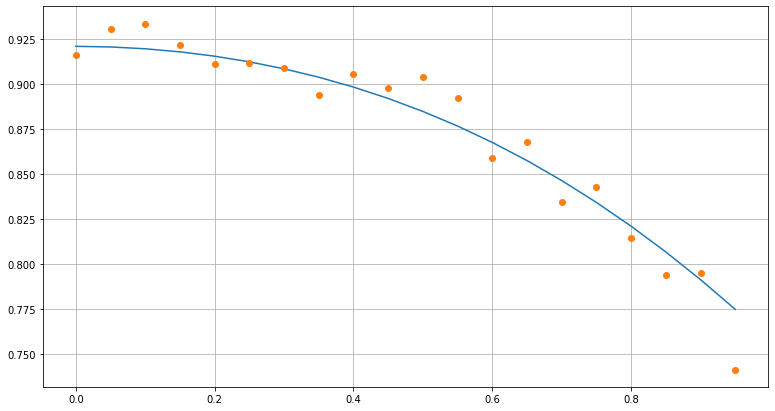

In [25]:
X = np.arange(0, 1, 0.05)
y = (np.sin(np.cos(X)) + 1)/2
y_noisy = y + np.random.randn(y.size)/80
plt.figure(figsize=(13, 7))
plt.plot(X, y)
plt.grid(True)
plt.plot(X, y_noisy, 'o')
X = X.reshape(-1, 1)
y_noisy = y_noisy.reshape(-1, 1)

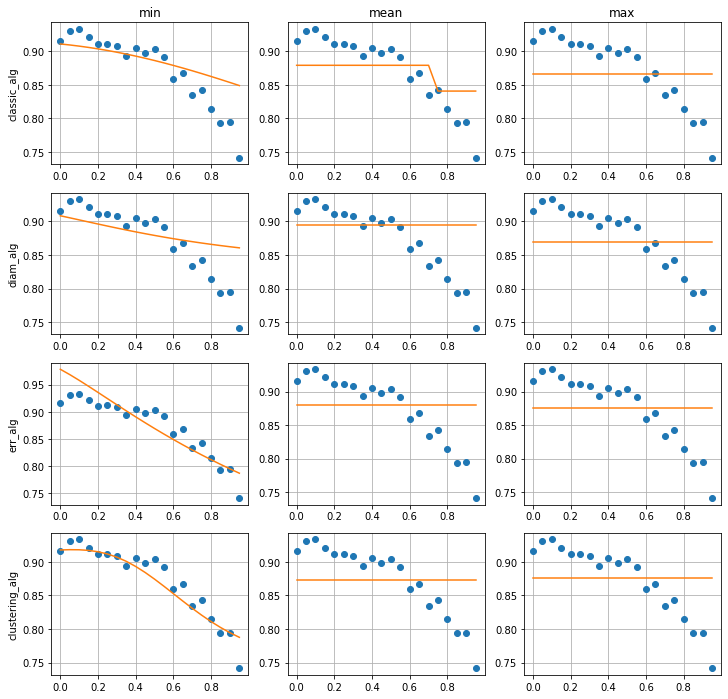

In [26]:
params = np.array([-2, -1, -0.5, 0.5, 1, 2])

plt.figure(figsize=(12, 12))

wann = genetic_alg_classic1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list,5, 5, (1, 15), [1, 1, 1], min_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 1)
plt.grid(True)
plt.ylabel("classic_alg")
plt.title("min")
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_classic1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list, 5, 5, (1, 15), [1, 1, 1], mean_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 2)
plt.grid(True)
plt.title('mean')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_classic1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list, 5, 5, (1, 15), [1, 1, 1], max_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 3)
plt.grid(True)
plt.title('max')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_diam1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                         output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                         [1, 1, 1], min_error, structural_metric1, 10, 15, 0, 50,
                         False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 4)
plt.grid(True)
plt.ylabel('diam_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_diam1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                         output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                         [1, 1, 1], mean_error, structural_metric1, 10, 15, 0, 50, 
                         False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 5)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_diam1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                         output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                         [1, 1, 1], max_error, structural_metric1, 10, 15, 0, 50, 
                         False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 6)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_err1(X, y_noisy, params, 10, 1, [], 1, function_list,
                        output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                        [1, 1, 1], min_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 7)
plt.grid(True)
plt.ylabel('err_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_err1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                        output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                        [1, 1, 1], mean_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 8)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_err1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                        output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                        [1, 1, 1], max_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 9)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_cluster1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                            [1, 1, 1], min_error, structural_metric1, 10, 0.9, 0, 50,
                            False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 10)
plt.grid(True)
plt.ylabel('clustering_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_cluster1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                            [1, 1, 1], mean_error, structural_metric1, 10, 0.9, 0, 
                            50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 11)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_cluster1(X, y_noisy, params, 10, 1, [], 1, function_list, 
                            output_list, 5, 5, (1, 15), [(3, 5), (5, 10), (3, 5)], 
                            [1, 1, 1], max_error, structural_metric1, 10, 0.9, 0, 50,
                            False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 12)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

plt.show()

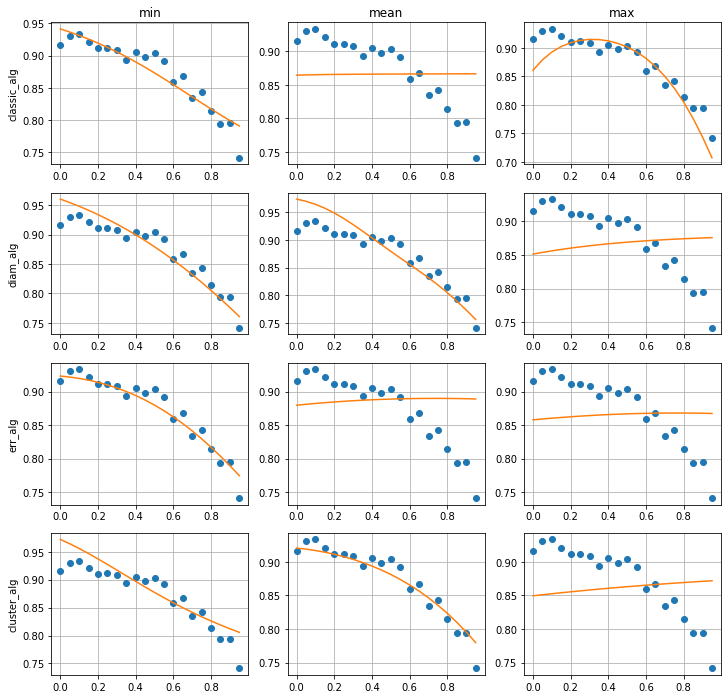

In [27]:
params = np.array([-2, -1, -0.5, 0.5, 1, 2])

plt.figure(figsize=(12, 12))

wann = genetic_alg_classic2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), [1, 1, 1], min_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 1)
plt.grid(True)
plt.title('min')
plt.ylabel('classic_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_classic2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), [1, 1, 1], mean_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 2)
plt.grid(True)
plt.title('mean')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_classic2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), [1, 1, 1], max_error, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 3)
plt.grid(True)
plt.title('max')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_diam2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                         5, (1, 10), (5, 30), [1, 1, 1], min_error, structural_metric1,
                         10, 15, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 4)
plt.grid(True)
plt.ylabel('diam_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_diam2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                         5, (1, 10), (5, 30), [1, 1, 1], mean_error, structural_metric1,
                         10, 15, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 5)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_diam2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                         5, (1, 10), (5, 30), [1, 1, 1], max_error, structural_metric1,
                         10, 15, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 6)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_err2(X, y_noisy, params, 10, 1, 1, function_list, output_list,
                        5, (1, 10), (5, 30), [1, 1, 1], min_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 7)
plt.grid(True)
plt.ylabel('err_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_err2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                        5, (1, 10), (5, 30), [1, 1, 1], mean_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 8)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_err2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                        5, (1, 10), (5, 30), [1, 1, 1], max_error, 10, 0.9, 0, 50, False)
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 9)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


wann = genetic_alg_cluster2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), (5, 30), [1, 1, 1], min_error, structural_metric1,
                            10, 0.9, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 10)
plt.grid(True)
plt.ylabel('cluster_alg')
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_cluster2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), (5, 30), [1, 1, 1], mean_error, structural_metric1,
                            10, 0.9, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 11)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())

wann = genetic_alg_cluster2(X, y_noisy, params, 10, 1, 1, function_list, output_list, 
                            5, (1, 10), (5, 30), [1, 1, 1], max_error, structural_metric1,
                            10, 0.9, 0, 50, False, len(function_list))
best_param = optimise_param(wann, X, y_noisy, np.arange(-10, 10, 0.1))
plt.subplot(4, 3, 12)
plt.grid(True)
plt.plot(X.flatten(), y_noisy.flatten(), 'o')
plt.plot(X.flatten(), wann.forward(X, np.array([best_param])).flatten())


plt.show()

### Classification

In [0]:
error1_1 = get_error_with_regularizer(min_error, regularizer, 10)
error1_2 = get_error_with_regularizer(mean_error, regularizer, 10)
error1_3 = get_error_with_regularizer(max_error, regularizer, 10)

error2_1 = get_error_with_regularizer(min_error, regularizer, 150)
error2_2 = get_error_with_regularizer(mean_error, regularizer, 150)
error2_3 = get_error_with_regularizer(max_error, regularizer, 150)

In [0]:
X, y = load_iris(True)
X = normalise(X)

In [0]:
def predict(wann, X, param):
    return wann.forward(X, np.array([param]))[0].argmax(axis=1)

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

def get_train_test():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    B = np.zeros((len(y_train), 3))
    for j in range(len(y_train)):
        B[j][y_train[j]] = 1
    return X_train, X_test, B, y_test

5 10 15 20 25 30 35 

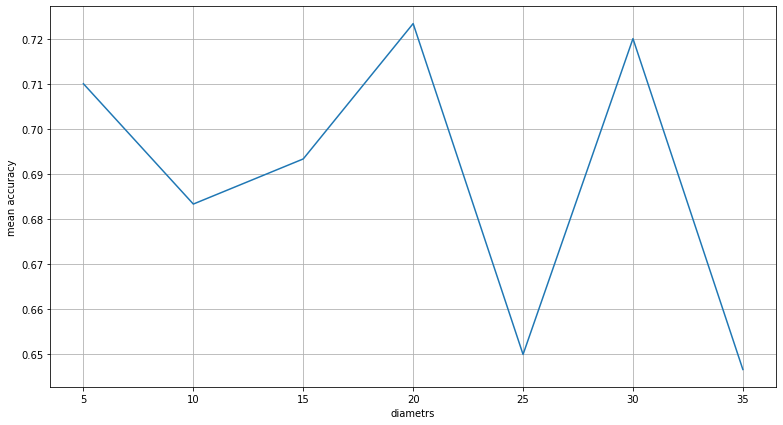

In [31]:
EXPERIMENTS_NUM = 10
diams = np.arange(5, 36, 5)
accuracies = []
for d in diams:
    print(d, end=' ')
    s = 0
    for _ in range(EXPERIMENTS_NUM):
        X_train, X_test, y_train, y_test = get_train_test()
        wann = genetic_alg_diam1(X_train, y_train, params, 10, 4, [], 3, function_list,
                                 output_list, 5, 5, (1, 15), [(2, 10), (2, 10), (2, 10)], 
                                 [1, 1, 1], error1_1, structural_metric1, 10, d, 0, 100, 
                                 False, len(function_list))
        best_param = optimise_param(wann, X_train, y_train, np.arange(-10, 10, 0.1))
        s += accuracy(predict(wann, X_test, best_param), y_test)
    accuracies.append(s/EXPERIMENTS_NUM)

plt.figure(figsize=(13, 7))
plt.grid(True)
plt.xlabel('diametrs')
plt.ylabel('mean accuracy')
plt.plot(diams, accuracies)

5 10 15 20 25 30 35 

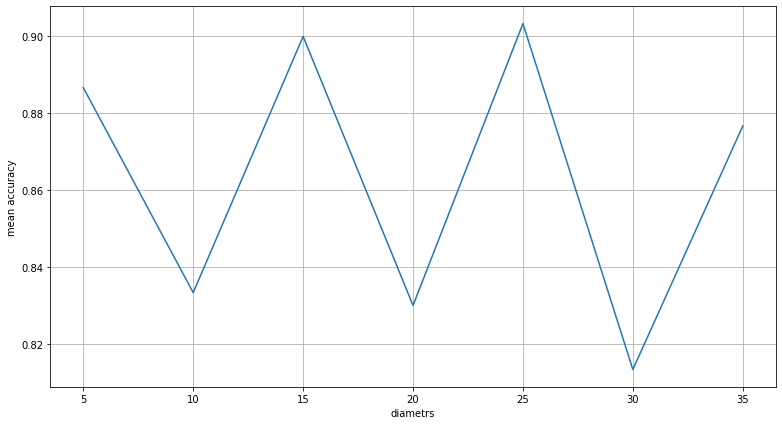

In [32]:
EXPERIMENTS_NUM = 10
diams = np.arange(5, 36, 5)
accuracies = []
for d in diams:
    print(d, end=' ')
    s = 0
    for _ in range(EXPERIMENTS_NUM):
        X_train, X_test, y_train, y_test = get_train_test()
        wann = genetic_alg_diam2(X_train, y_train, params, 10, 4, 3, function_list, 
                                 output_list, 10, (1, 10), (5, 30), [1, 1, 1], error2_1, 
                                 structural_metric1, 10, d, 0, 100, False, len(function_list))
        best_param = optimise_param(wann, X_train, y_train, np.arange(-10, 10, 0.1))
        s += accuracy(predict(wann, X_test, best_param), y_test)
    accuracies.append(s/EXPERIMENTS_NUM)

plt.figure(figsize=(13, 7))
plt.grid(True)
plt.xlabel('diametrs')
plt.ylabel('mean accuracy')
plt.plot(diams, accuracies)

0.86 0.88 0.9 0.92 0.9400000000000001 0.9600000000000001 0.9800000000000001 

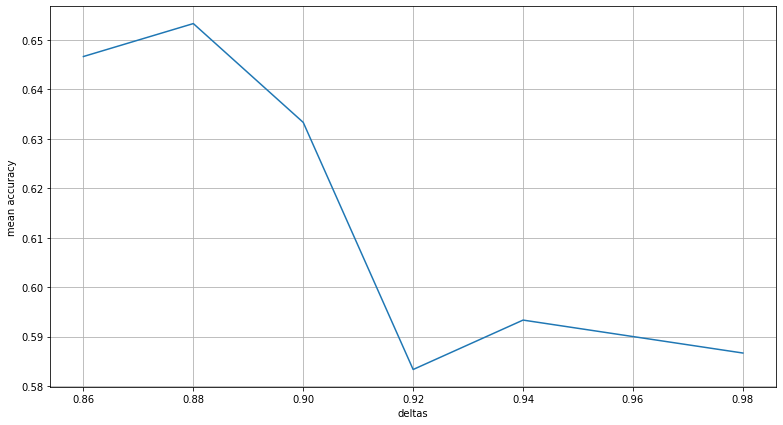

In [33]:
EXPERIMENTS_NUM = 10
deltas = np.arange(0.86, 0.99, 0.02)
accuracies = []
for d in deltas:
    print(d, end=' ')
    s = 0
    for _ in range(EXPERIMENTS_NUM):
        X_train, X_test, y_train, y_test = get_train_test()
        wann = genetic_alg_err1(X_train, y_train, params, 10, 4, [], 3, function_list, 
                                output_list, 5, 5, (3, 15), [(2, 10), (2, 10), (2, 10)], 
                                [1, 1, 1], error1_1, 10, d, 0, 100, False)
        best_param = optimise_param(wann, X_train, y_train, np.arange(-10, 10, 0.1))
        s += accuracy(predict(wann, X_test, best_param), y_test)
    accuracies.append(s/EXPERIMENTS_NUM)

plt.figure(figsize=(13, 7))
plt.grid(True)
plt.xlabel('deltas')
plt.ylabel('mean accuracy')
plt.plot(deltas, accuracies)

0.86 0.88 0.9 0.92 0.9400000000000001 0.9600000000000001 0.9800000000000001 

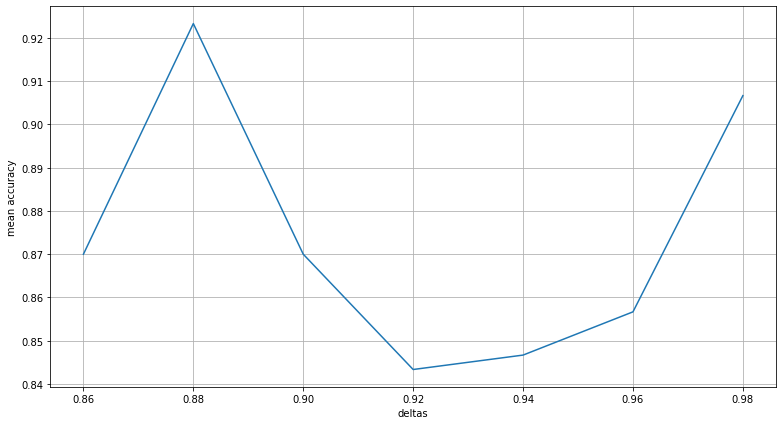

In [35]:
EXPERIMENTS_NUM = 10
deltas = np.arange(0.86, 0.99, 0.02)
accuracies = []
for d in deltas:
    print(d, end=' ')
    s = 0
    for _ in range(EXPERIMENTS_NUM):
        X_train, X_test, y_train, y_test = get_train_test()
        wann = genetic_alg_err2(X_train, y_train, params, 10, 4, 3, function_list, 
                                output_list, 10, (1, 10), (5, 30), [1, 1, 1], 
                                error2_1, 10, d, 0, 100, False)
        best_param = optimise_param(wann, X_train, y_train, np.arange(-10, 10, 0.1))
        s += accuracy(predict(wann, X_test, best_param), y_test)
    accuracies.append(s/EXPERIMENTS_NUM)

plt.figure(figsize=(13, 7))
plt.grid(True)
plt.xlabel('deltas')
plt.ylabel('mean accuracy')
plt.plot(deltas, accuracies)

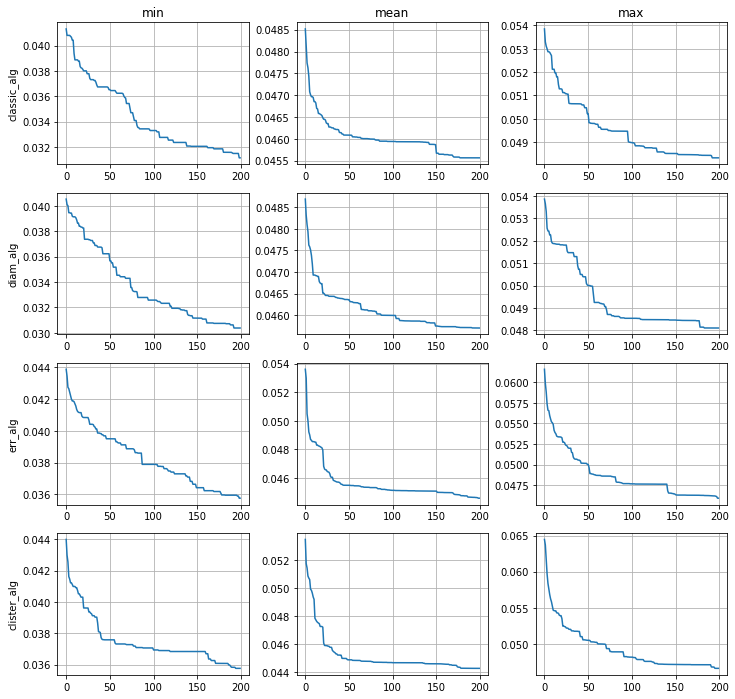

In [37]:
params = np.array([-2, -1, -0.5, 0.5, 1, 2])
EPOCHS = 200
EXPERIMENTS_NUM = 10
POPULATION_SIZE = 10
MUTATIONS_NUM = 5
CROSSOVERS_NUM = 5
LAYERS_SIZE = []
NEW_LAYER_SIZE = (1, 15)
WEIGHTS = [1, 1, 1]
DELTA_DIAM = 20
DELTA_ERR = 0.88
FREQUENCY = 10
GRID = np.arange(-10, 10, 0.1)
INPUT_LEN = 4
OUTPUT_LEN = 3
REGENERATION_LAYERS_SIZE = [(1, 15), (1, 15), (1, 15)]

accuracies = []

plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.25)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic1(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                         NEW_LAYER_SIZE, WEIGHTS, error1_1, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 1)
plt.grid(True)
plt.title('min')
plt.ylabel('classic_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic1(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                         NEW_LAYER_SIZE, WEIGHTS, error1_2, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 2)
plt.grid(True)
plt.title('mean')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic1(X_train, y_train, params, POPULATION_SIZE,
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                         NEW_LAYER_SIZE, WEIGHTS, error1_3, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 3)
plt.grid(True)
plt.title('max')
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam1(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list, 
                                      output_list, MUTATIONS_NUM, CROSSOVERS_NUM, 
                                      NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                      WEIGHTS, error1_1, structural_metric1,
                                      FREQUENCY, DELTA_DIAM, 0, EPOCHS,
                                      True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 4)
plt.grid(True)
plt.ylabel('diam_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam1(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                      output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                      NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                      WEIGHTS, error1_2, structural_metric1,
                                      FREQUENCY, DELTA_DIAM, 0, EPOCHS,
                                      True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 5)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam1(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                      output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                      NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                      WEIGHTS, error1_3, structural_metric1,
                                      FREQUENCY, DELTA_DIAM, 0, EPOCHS,
                                      True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 6)
plt.grid(True)
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err1(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                     output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                     NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE, 
                                     WEIGHTS, error1_1, FREQUENCY, DELTA_ERR, 0, 
                                     EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 7)
plt.grid(True)
plt.ylabel('err_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err1(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list,
                                     output_list, MUTATIONS_NUM, CROSSOVERS_NUM,
                                     NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE, 
                                     WEIGHTS, error1_2, FREQUENCY, DELTA_ERR, 0,
                                     EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 8)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err1(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list, 
                                     output_list, MUTATIONS_NUM, CROSSOVERS_NUM, 
                                     NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                     WEIGHTS, error1_3, FREQUENCY, DELTA_ERR, 0,
                                     EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 9)
plt.grid(True)
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster1(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM, 
                                         NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE, 
                                         WEIGHTS, error1_1, structural_metric1, 
                                         FREQUENCY, DELTA_ERR, 0, EPOCHS,
                                         True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 10)
plt.grid(True)
plt.ylabel('clister_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster1(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM, 
                                         NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                         WEIGHTS, error1_2, structural_metric1, 
                                         FREQUENCY, DELTA_ERR, 0, EPOCHS,
                                         True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 11)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster1(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, LAYERS_SIZE, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, CROSSOVERS_NUM, 
                                         NEW_LAYER_SIZE, REGENERATION_LAYERS_SIZE,
                                         WEIGHTS, error1_3, structural_metric1, 
                                         FREQUENCY, DELTA_ERR, 0, EPOCHS,
                                         True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 12)
plt.grid(True)
plt.plot(histories)

plt.show()

In [38]:
print(accuracies)

[0.73, 0.31999999999999995, 0.35, 0.7133333333333333, 0.35, 0.3366666666666667, 0.6266666666666666, 0.42000000000000004, 0.32333333333333336, 0.6366666666666666, 0.41, 0.3466666666666667]


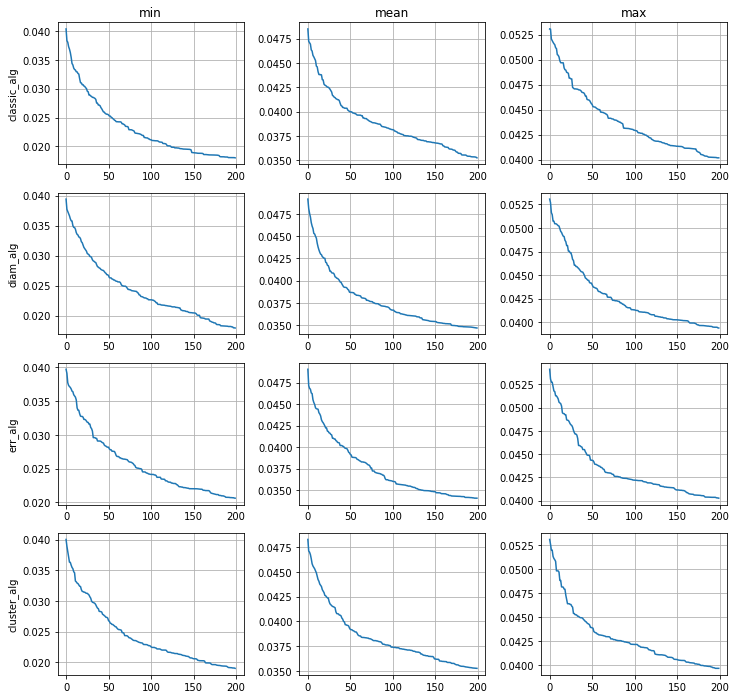

In [44]:
params = np.array([-2, -1, -0.5, 0.5, 1, 2])
EPOCHS = 200
EXPERIMENTS_NUM = 10
POPULATION_SIZE = 10
MUTATIONS_NUM = 10
MUTATION_STRENGTH = (1, 10)
REGENERATION_STRENGTH = (5, 30)
WEIGHTS = [1, 1, 1]
DELTA_DIAM = 25
DELTA_ERR = 0.88
FREQUENCY = 10
GRID = np.arange(-10, 10, 0.1)

accuracies = []

plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic2(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                         MUTATIONS_NUM, MUTATION_STRENGTH, WEIGHTS, 
                                         error2_1, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 1)
plt.grid(True)
plt.title('min')
plt.ylabel('classic_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic2(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, OUTPUT_LEN, function_list, output_list,
                                         MUTATIONS_NUM, MUTATION_STRENGTH, WEIGHTS,
                                         error2_2, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 2)
plt.grid(True)
plt.title('mean')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_classic2(X_train, y_train, params, POPULATION_SIZE,
                                         INPUT_LEN, OUTPUT_LEN, function_list,
                                         output_list, MUTATIONS_NUM, 
                                         MUTATION_STRENGTH, WEIGHTS, 
                                         error2_3, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 3)
plt.grid(True)
plt.title('max')
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam2(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                      MUTATIONS_NUM, MUTATION_STRENGTH, 
                                      REGENERATION_STRENGTH, WEIGHTS, error2_1, 
                                      structural_metric1, FREQUENCY, DELTA_DIAM,
                                      0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 4)
plt.grid(True)
plt.ylabel('diam_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam2(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                      MUTATIONS_NUM, MUTATION_STRENGTH, REGENERATION_STRENGTH, 
                                      WEIGHTS, error2_2, structural_metric1, FREQUENCY, 
                                      DELTA_DIAM, 0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 5)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_diam2(X_train, y_train, params, POPULATION_SIZE, 
                                      INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                      MUTATIONS_NUM, MUTATION_STRENGTH, REGENERATION_STRENGTH,
                                      WEIGHTS, error2_3, structural_metric1, FREQUENCY,
                                      DELTA_DIAM, 0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 6)
plt.grid(True)
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err2(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                     MUTATIONS_NUM, MUTATION_STRENGTH, REGENERATION_STRENGTH,
                                     WEIGHTS, error2_1, FREQUENCY, DELTA_ERR, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 7)
plt.grid(True)
plt.ylabel('err_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err2(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, OUTPUT_LEN, function_list, output_list, 
                                     MUTATIONS_NUM, MUTATION_STRENGTH, REGENERATION_STRENGTH,
                                     WEIGHTS, error2_2, FREQUENCY, DELTA_ERR, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 8)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_err2(X_train, y_train, params, POPULATION_SIZE, 
                                     INPUT_LEN, OUTPUT_LEN, function_list, output_list,
                                     MUTATIONS_NUM, MUTATION_STRENGTH, REGENERATION_STRENGTH, 
                                     WEIGHTS, error2_3, FREQUENCY, DELTA_ERR, 0, EPOCHS, True)
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 9)
plt.grid(True)
plt.plot(histories)


s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster2(X_train, y_train, params, POPULATION_SIZE,
                                         INPUT_LEN, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, MUTATION_STRENGTH,
                                         REGENERATION_STRENGTH, WEIGHTS, error2_1, 
                                         structural_metric1, FREQUENCY, DELTA_ERR, 
                                         0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 10)
plt.grid(True)
plt.ylabel('cluster_alg')
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster2(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, MUTATION_STRENGTH, 
                                         REGENERATION_STRENGTH, WEIGHTS, error2_2, 
                                         structural_metric1, FREQUENCY, DELTA_ERR, 
                                         0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 11)
plt.grid(True)
plt.plot(histories)

s = 0
histories = []
for _ in range(EXPERIMENTS_NUM):
    X_train, X_test, y_train, y_test = get_train_test()
    wann, history = genetic_alg_cluster2(X_train, y_train, params, POPULATION_SIZE, 
                                         INPUT_LEN, OUTPUT_LEN, function_list, 
                                         output_list, MUTATIONS_NUM, MUTATION_STRENGTH,
                                         REGENERATION_STRENGTH, WEIGHTS, error2_3,
                                         structural_metric1, FREQUENCY, DELTA_ERR,
                                         0, EPOCHS, True, len(function_list))
    histories.append(history)
    best_param = optimise_param(wann, X_train, y_train, GRID)
    s += accuracy(predict(wann, X_test, best_param), y_test)
accuracies.append(s/EXPERIMENTS_NUM)
histories = np.array(histories).mean(axis=0)
plt.subplot(4, 3, 12)
plt.grid(True)
plt.plot(histories)

plt.show()

In [46]:
accuracies

[0.93,
 0.8433333333333334,
 0.6433333333333333,
 0.9366666666666668,
 0.7766666666666667,
 0.7066666666666667,
 0.9400000000000001,
 0.8766666666666667,
 0.6633333333333333,
 0.9233333333333335,
 0.8933333333333333,
 0.7099999999999999]